<a href="https://colab.research.google.com/github/sergiokapone/DataScience/blob/main/Hw10/HW10_2_vgg16_t4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, utils
from tensorflow.keras.datasets import fashion_mnist
from keras.callbacks import ModelCheckpoint, EarlyStopping

from google.colab import drive
drive.mount('/content/drive')
model_file = '/content/drive/MyDrive/Colab Notebooks/HW/weights.keras'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Про dataset `fashion-mnist`

Fashion-MNIST — це набір зображень статей Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад являє собою зображення в градаціях сірого 28x28, пов'язане з міткою з 10 класів:

| Мітка | Опис        | Переклад         |
|-------|-------------|------------------|
| 0     | T-shirt/top | Футболка/сорочка |
| 1     | Trouser     | Штани            |
| 2     | Pullover    | Светр            |
| 3     | Dress       | Плаття           |
| 4     | Coat        | Пальто           |
| 5     | Sandal      | Сандалі          |
| 6     | Shirt       | Сорочка          |
| 7     | Sneaker     | Кросовки         |
| 8     | Bag         | Сумка            |
| 9     | Ankle boot  | Чоботи           |

# Константи

In [2]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}
input_shape = (32, 32)

TRAINING = (
    False  # Константа, якак визначає. чи треба навчати, чи використовувати модель
)

# Підготовка даних

In [3]:
(x_train_orig, y_train), (x_test_orig, y_test) = tf.keras.datasets.fashion_mnist.load_data()


# Попереднє оброблення даних
def preprocess_images(images):
    # Додамо до зображень додаткові канали
    images = np.stack((images,) * 3, axis=-1)
    images = images.astype("float32") / 255.0
    return images


x_train = preprocess_images(x_train_orig)
x_test = preprocess_images(x_test_orig)

# Зміна розмірності з використанням tf.image
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))



# Побудова архітектури нейронної мережі (моделі)

In [4]:
def build_model():
    # Завантаження попередньо навченої моделі VGG16 без Fully Connected шарів
    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_tensor=layers.Input(shape=(32, 32, 3)),
    )

    # Заморожуємо ваги попередньо навченої частини моделі
    for layer in base_model.layers:
        layer.trainable = True

    model = Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(10, activation="softmax"))
    return model

# Створення моделі

In [5]:
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

if os.path.exists("/content/drive/MyDrive/Colab Notebooks/HW/weights.keras"):
    model.load_weights("/content/drive/MyDrive/Colab Notebooks/HW/weights.keras")
    print("Завантажено збережені ваги.")
else:
    print("Ваги не знайдено, починаємо навчання заново.")

Завантажено збережені ваги.


# Тренування на GPU T4 в Google Colab

Якщо модель натренована. то пропускаємо цей етап


In [6]:
print(tf.test.gpu_device_name())

if TRAINING:
    checkpoint = ModelCheckpoint(
        "./vgg16_weights.keras", monitor="val_loss", save_best_only=True
    )

    early_stopping = EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.0001,
        patience=0,
        mode="auto",
        baseline=0.93,
        restore_best_weights=False,
    )

    history = model.fit(
        x_train,
        y_train,
        epochs=10,
        steps_per_epoch=60,
        callbacks=[early_stopping],
        validation_data=(x_test, y_test),
    )

    # Оцінка моделі на тестовому наборі даних
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
    print(f"\nТочність на тестовому наборі: {test_accuracy:.2f}")

/device:GPU:0


# Перевірка результатів

In [7]:
predictions = model.predict(x_test)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nТочність на тестовому наборі: {test_accuracy:.2f}")

313/313 [==============================] - 7s 9ms/step

Точність на тестовому наборі: 0.93


# Візуалізація передбачень

In [8]:
number_of_images = 40 # розмр вибірки зображень

In [20]:
# Знайдемо seed при якому розпізнані всі зображення із рандомної вибірки
for seed in range(1, 100, 1):
    np.random.seed(seed)
    count = 0

    for sample_index in range(number_of_images):
        sample_index = np.random.choice(10000)
        prob = predictions[sample_index]
        predicted_label = np.argmax(prob)

        if predicted_label == y_test[sample_index]:
            count += 1

    accuracy = count / number_of_images
    if int(accuracy) == 1:
        print(f"Seed {seed}: {accuracy * 100:.0f}% accuracy")


Seed 35: 100% accuracy
Seed 50: 100% accuracy
Seed 51: 100% accuracy
Seed 56: 100% accuracy
Seed 73: 100% accuracy
Seed 79: 100% accuracy


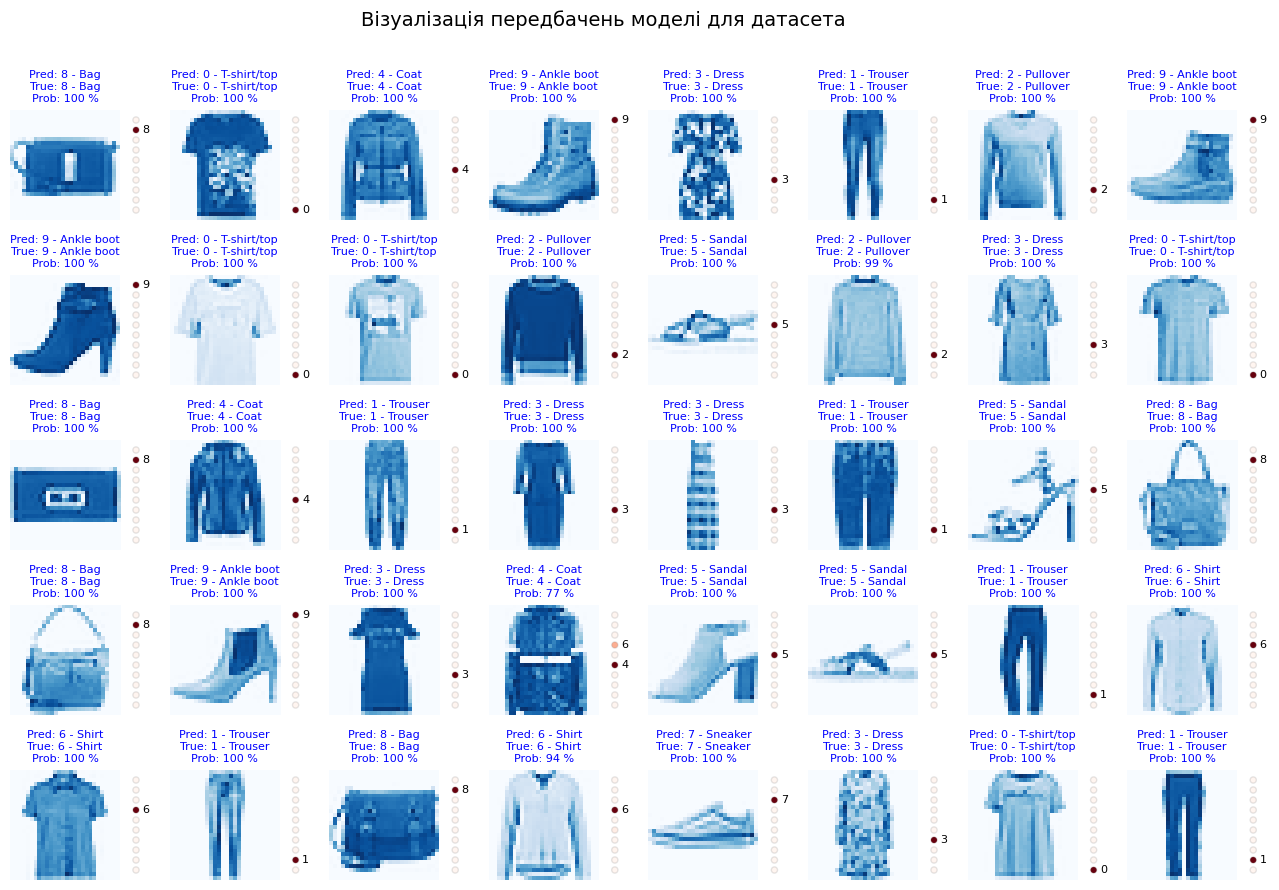

In [17]:

f, ax = plt.subplots(5, 8, figsize=(16, 10))
f.subplots_adjust(hspace=0.5, wspace=0.3)

np.random.seed(35)
f.suptitle(f"Візуалізація передбачень моделі для датасета", fontsize=14)

for axes_index, sample_index in enumerate(np.random.choice(10000, number_of_images)):
    prob = predictions[sample_index]
    img, true_label = x_test_orig[sample_index], y_test[sample_index]
    predicted_label = np.argmax(prob)
    if predicted_label == true_label:
        color = "blue"
        cmap = "Blues"
    else:
        color = "red"
        cmap = "Reds"

    ax[axes_index // 8, axes_index % 8].imshow(img, cmap=cmap)
    ax[axes_index // 8, axes_index % 8].axis("off")
    ax[axes_index // 8, axes_index % 8].set_title(
        f"Pred: {predicted_label} - {class_labels.get(predicted_label)}\nTrue: {true_label} - {class_labels.get(true_label)}\nProb: {prob.max()*100:.0f} %",
        fontsize=8,
        color=color,
    )

    inset_ax = f.add_axes(
        [
            ax[axes_index // 8, axes_index % 8].get_position().x1,
            ax[axes_index // 8, axes_index % 8].get_position().y0,
            0.02,
            ax[axes_index // 8, axes_index % 8].get_position().height,
        ]
    )

    classes = np.arange(len(class_labels))
    inset_ax.scatter(
        np.ones(10) * 0.5,
        classes,
        s=20,
        c=prob,
        cmap="Reds",
        marker="o",
        edgecolor=(0.5, 0.5, 0.5, 0.2),
        linewidths=1,
    )
    inset_ax.set_xlim(0, 1)
    inset_ax.set_ylim(-1, 10)
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.axis("off")
    for i, p in enumerate(prob):
        if p > 0.1:
            inset_ax.text(0.7, i, f"{i}", fontsize=8, verticalalignment="center")

plt.show()

На рандомно вибраних сорока зображеннях знайшов вибірку, де стовідсотково всі тестові зразки розпіднані правильно.


# Висновки

Використання CPU для тренування займає дкже багато часу, тому я вирішив використати GPU. яку представляє середовище Google Colab.

Для навчання я використав уже готову структуру `VGG16` з  пакету `keras`. Я якості top-level шару я використав дошарову повнозв'язну мережу, якак мала на вихідному шарі 10 нейронів за силом категорій.

Згорткову частину `VGG16` можна було як навчити наново, так і використати вже ваги, які були натреновані. Я вирішив спочатку тренувати всю мережу
```python
layer.trainable = True
```
Варіант, коли ваги `CNN` частини заморожені і представлені самим пакетом `keras`
```python
layer.trainable = False
```
планується перевірити згодом, оскільки безкоштовний тариф не дає змоги проводити тривалі експерименти з тренуванням.

Отже, в результаті використання згорткової нейронної мережі VGG16 вдалось досягти точності 0.93. На відміну від попередньої згорткової моделі, за допомогою структури `VGG16` вдається трохи підвищити точність на тестових даних, в моєму випадку, це трохи більше 1-го відсотка.
